# Ruido

### -1. Sacar fotos con el objetivo tapado
### 0. Repaso: Ruido Blanco
### 1. Leer fotos
### 2. Inspección
### 3. Ruido en el campo del sensor
#### 3.1. Ruido por color y por píxel
#### 3.2. Estadísticas de ruido: relación entre media y desvío
### 4. Histograma

# 0. Repaso: Ruido Blanco

Vamos a generar un poco de ruido y medirlo, para entender qué hacemos después.
Repasar qué era la distribución "normal" (Campana de Gauss), qué significan "media" y "desvío" y cómo trabajamos con esas cosas en python con numpy.

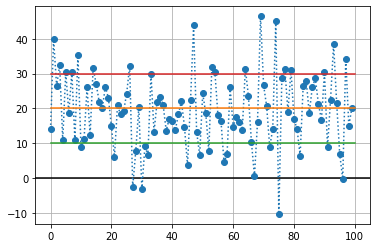

In [1]:
import numpy as np
import matplotlib.pyplot as plt


n_muestras = 500000

media = 20
std = 10
x = np.random.normal(media, std, n_muestras)

y = x

n_show = np.min([n_muestras, 100])

plt.axhline(color='k')
plt.grid()

plt.plot(y[:n_show], 'o:')
plt.plot([0, n_show], [media, media])
plt.plot([0, n_show], [media-std, media-std])
plt.plot([0, n_show], [media+std, media+std])

$$ f(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2} $$

Diferencia entre media y media estimada = -0.00956502645365731


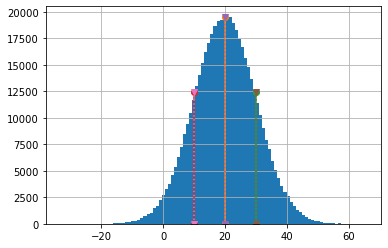

In [2]:
h, bins, patches = plt.hist(y, bins=100)
bin_max = np.argmax(h)
h_max = h[bin_max]

plt.grid()
plt.plot([media, media], [0, h_max], 'o-')
plt.plot([media+std, media+std], [0, h_max*.635], 'o-')
plt.plot([media-std, media-std], [0, h_max*.635], 'o-')

media_est = np.mean(y)
std_est = np.std(y)

plt.plot([media_est, media_est], [0, h_max], 'v:')
plt.plot([media_est+std_est, media_est+std_est], [0, h_max*.635], 'v:')
plt.plot([media_est-std_est, media_est-std_est], [0, h_max*.635], 'v:')

error_en_media_est = (media - media_est)
print('Diferencia entre media y media estimada =', error_en_media_est)                




In [3]:
# Cargamos las bibliotecas que usamos casi siempre

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print('OpenCV ' + cv2.__version__)
print('numpy ' + np.__version__)

OpenCV 4.5.1
numpy 1.19.2


# 1. Análisis Global Estadístico
## 1.1. Capturar fotos con la cámara tapada y cargarlas
ponerlas en el subdirectorio "fotos"

In [4]:
# !ls -lh fotos
# Leemos lista de fotos que vamos a procesar
# glob nos permite crear lista con nombres de archivo en un directorio
from glob import glob
img_fnames = glob('./Fotos_negras/*.jpg')
print(img_fnames)

['./Fotos_negras/IMG_20210508_125902.jpg', './Fotos_negras/IMG_20210508_125928.jpg', './Fotos_negras/IMG_20210508_125921.jpg', './Fotos_negras/IMG_20210508_125906.jpg', './Fotos_negras/IMG_20210508_125916.jpg', './Fotos_negras/IMG_20210508_125904.jpg', './Fotos_negras/IMG_20210508_125909.jpg', './Fotos_negras/IMG_20210508_125913.jpg', './Fotos_negras/IMG_20210508_125919.jpg', './Fotos_negras/IMG_20210508_125924.jpg', './Fotos_negras/IMG_20210508_125900.jpg']


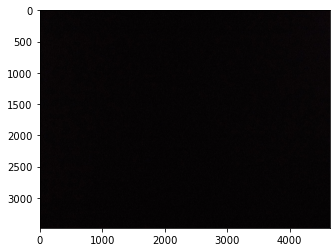

In [5]:
# Vamos a mostrar una de las fotos a ver qué salió, ¡tendría que ser todo negro!

img = cv2.imread(img_fnames[0])

# pasamos a RGB (acuérdense que OpenCV usa BGR!)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

img.shape = (3480, 4640, 3)
La transponemos:
alto = 3480px, ancho = 4640px


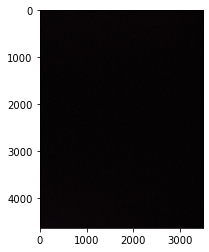

In [6]:
# Viendo la imagen que salió notamos que está bien que sea toda negra, pero está vertical en vez de apaisada...
# !exiftool fotos/1.jpg | egrep Width
print("img.shape =", img_rgb.shape)
print("La transponemos:")
img_t = cv2.transpose(img_rgb)
alto = img_t.shape[1]
ancho = img_t.shape[0]
print("alto = {0}px, ancho = {1}px".format(alto, ancho)) # img.shape = (alto, ancho)
plt.imshow(img_t)

In [7]:
# ¡Ahora sí!
# Vamos a leer todas en memoria, pasarlas a RGB y de paso asegurarnos que estén apaisadas.
# (si van a trabajar con muchas imágenes entonces mejor no leerlas todas de una, 
# al que quiera profundizar puede pensar cómo modifcar lo que sigue para procesar muchas imágenes
# o también puede leer acerca de generadores ("python generators").

imgs = []
for fname in img_fnames:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape[0] > img.shape[1]:
        img = cv2.transpose(img)
    imgs.append(img)

print("Se cargaron {0} imágenes".format(len(imgs)))


Se cargaron 11 imágenes


# 2. Inspección

In [8]:
# Ahora vamos a empezar a investigar un poco qué capturó nuestro sensor... ya vimos que sale todo negro, pero ¿qué tan negro es ese color negro?

# vamos a agarrar una imagen al azar, por ejemplo la 3era:
img = imgs[2]
# y ver el menor valor de intensidad que registró
print("Menor intensidad =", np.min([img]))
# esperablemente ese valor debe ser 0, ¿pero el máximo?
print("Mayor intensidad =", np.max([img]))
# es distinto de cero!!


Menor intensidad = 0
Mayor intensidad = 59


Mayor intensidad = 255


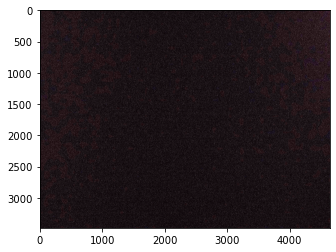

In [9]:
# Ok, podemos normalizar la imágen a ver qué pasó

img_norm = cv2.normalize(img, 0, 255, norm_type=cv2.NORM_INF)
# ojo acá al normalizar es común usar NORM_MINMAX, si el mínimo de la imagen es 0 entonces son lo mismo, pero si llegara a ser distinto de cero entonces NORM_MINMAX correría el mínimo a cero y perderíamos información de ruido, en este caso sería un offset. NORM_INF nos da la norma infinito de la matriz (el máximo de los valores absolutos de los elementos).
print("Mayor intensidad =", np.max([img_norm]))

plt.imshow(img_norm)
# bueno ahora díganme si era todo tan negro como parecía...

# 3. Ruido en el campo del sensor

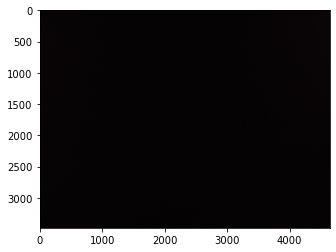

In [10]:
# Vamos a ver qué pasa si promediamos sobre varias fotos.

# esto que sigue se puede hacer en una sola línea con numpy... ¿Quién se anima?
img_promedio = np.zeros_like(imgs[0])
n = len(imgs)
for img in imgs:
    # este siguiente paso es medio una barbaridad y se presta a errores de conversion de tipo pero es lo más "didáctico" para ver qué estamos haciendo...
    img_promedio = img_promedio + img/n

# convertimos de nuevo a char
img_promedio = img_promedio.astype(np.uint8)

plt.imshow(img_promedio)
# ¿sigue siendo todo negro...?

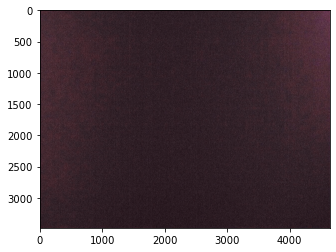

In [11]:
# a ver si lo normalizamos...
img_promedio_norm = cv2.normalize(img_promedio, 0, 255, norm_type=cv2.NORM_INF)
plt.imshow(img_promedio_norm)


## 3.1. Ruido por color y por píxel

In [12]:
# de nuevo esto se puede hacer en menos líneas usando cuentas a lo largo de dimensiones con numpy, se animan a optimizarlo?

# OK si tarda mucho cancelen y vayan a la celda que sigue

# img_media = np.zeros((alto, ancho, 3))
# img_std = np.zeros((alto, ancho, 3))
# for fil in range(ancho):
#     for col in range(alto):
#         for c in range(3):
#             valores = []
#             for img in imgs:
#                 valores.append(img[col, fil, c])
#             # img_media[fil, col, c] = np.mean(valores)
#             img_std[fil, col,c ] = np.std(valores)

# plt.imshow(img_media)

In [13]:
# Ok, si lo de arriba les tarda una eternidad entonces hacemos esto otro:

# acá lo que hacemos es apilar todas las imágenes:
imgs_np = np.stack(imgs)

# Media:
img_media = np.mean(imgs_np, axis=0)

# desvío:
img_std = np.std(imgs_np, axis=0)

print(imgs_np.shape)
# para ver los resultados vamos a dibujar contornos:

(11, 3480, 4640, 3)


In [14]:
print(img_media.shape)
print(img_std.shape)

(3480, 4640, 3)
(3480, 4640, 3)


In [15]:
def dibujar_contorno(mat):
    fig = plt.figure()
    X, Y = np.meshgrid(range(ancho), range(alto))
    Z = mat

    # decimación para no matar la compu calculando contornos!
    dec = 16

    fig = plt.figure(figsize=(16,12))
    cp = plt.contourf(X[::dec], Y[::dec], Z[::dec])
    fig.colorbar(cp)
    plt.show()

Std Rojo


<Figure size 432x288 with 0 Axes>

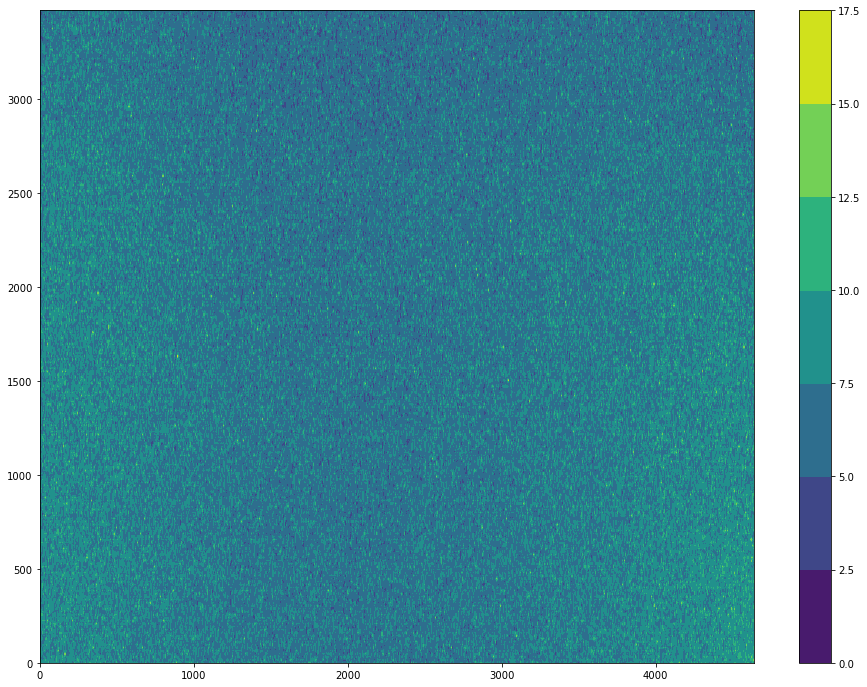

In [16]:
print('Std Rojo')
dibujar_contorno(img_std[:,:,0])

Std Verde


<Figure size 432x288 with 0 Axes>

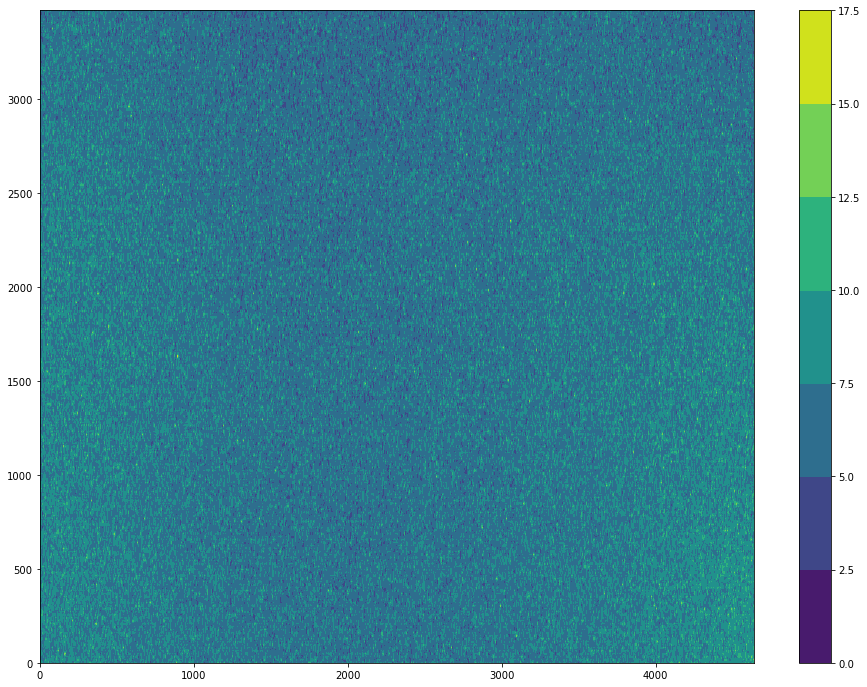

In [17]:
print('Std Verde')
dibujar_contorno(img_std[:,:,1])

Std Azul


<Figure size 432x288 with 0 Axes>

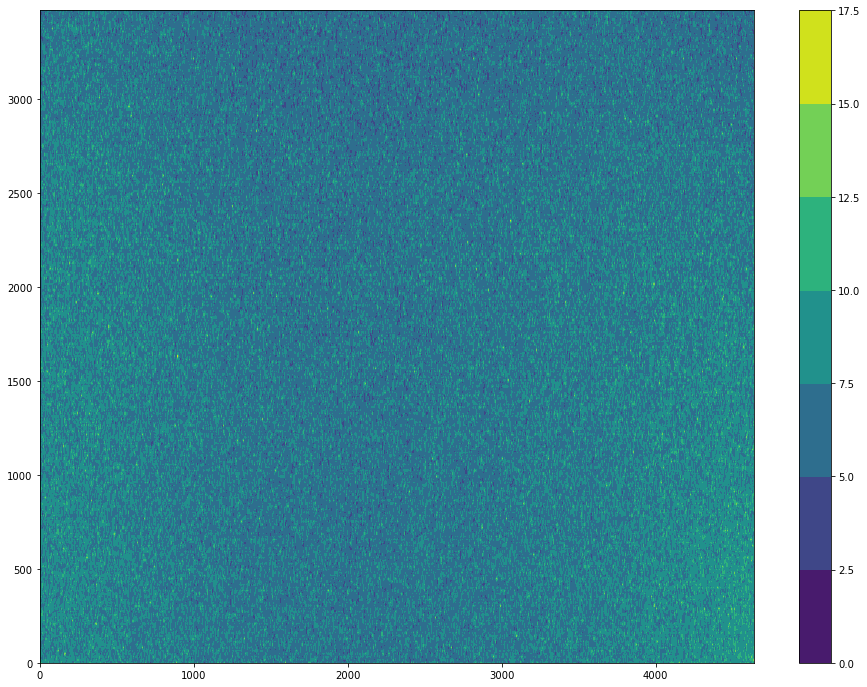

In [18]:
print('Std Azul')
dibujar_contorno(img_std[:,:,2])

Media Rojo


<Figure size 432x288 with 0 Axes>

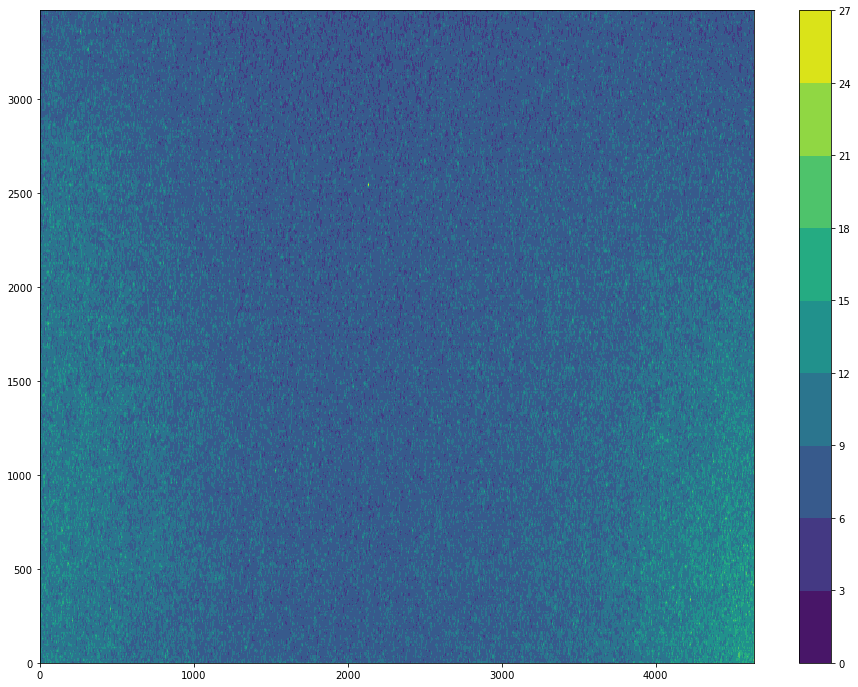

In [19]:
print('Media Rojo')
dibujar_contorno(img_media[:,:,0])

Media Verde


<Figure size 432x288 with 0 Axes>

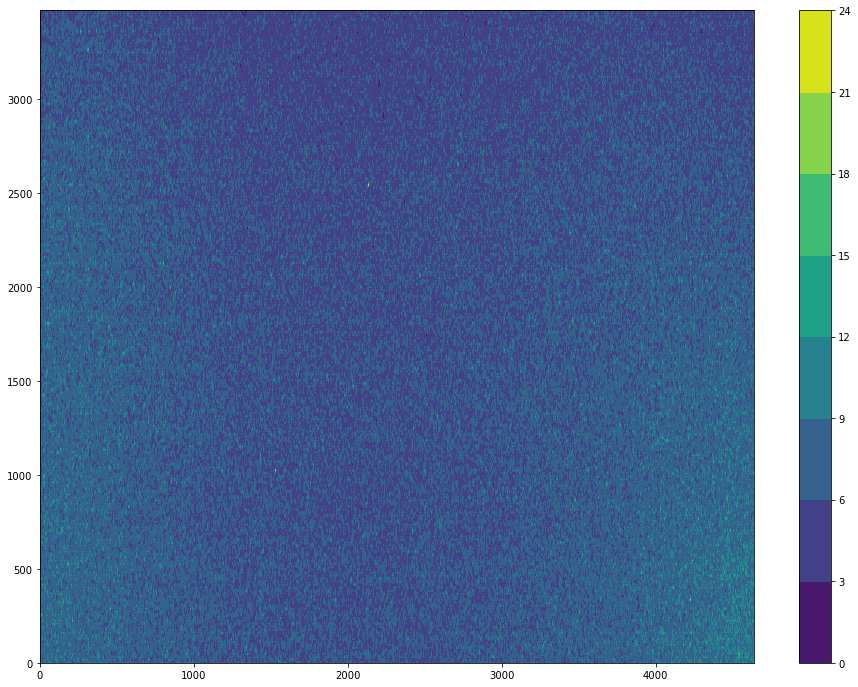

In [20]:
print('Media Verde')
dibujar_contorno(img_media[:,:,1])

Media Azul


<Figure size 432x288 with 0 Axes>

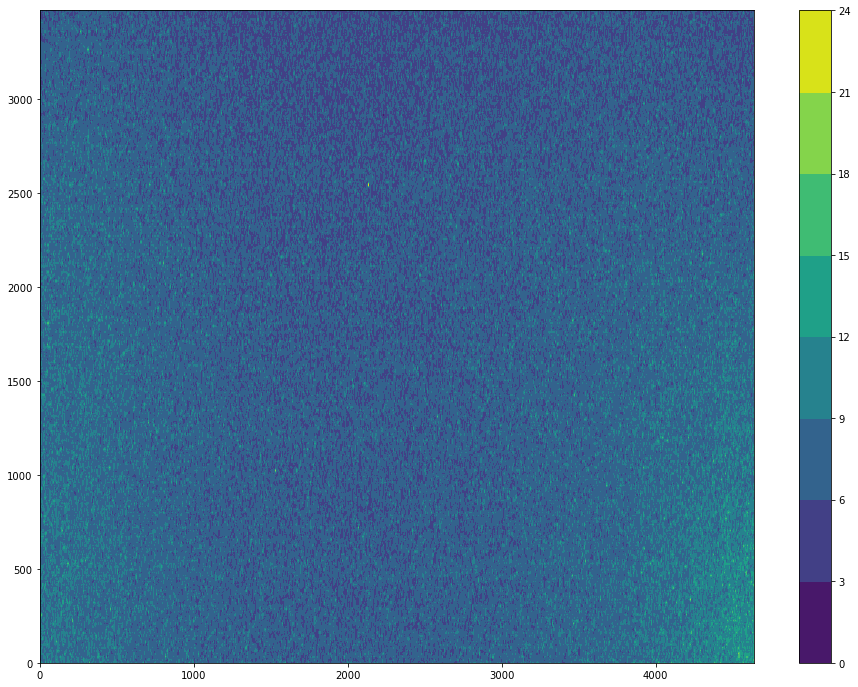

In [21]:
print('Media Azul')
dibujar_contorno(img_media[:,:,2])

## 3.2. Estadísticas de ruido: relación entre media y desvío

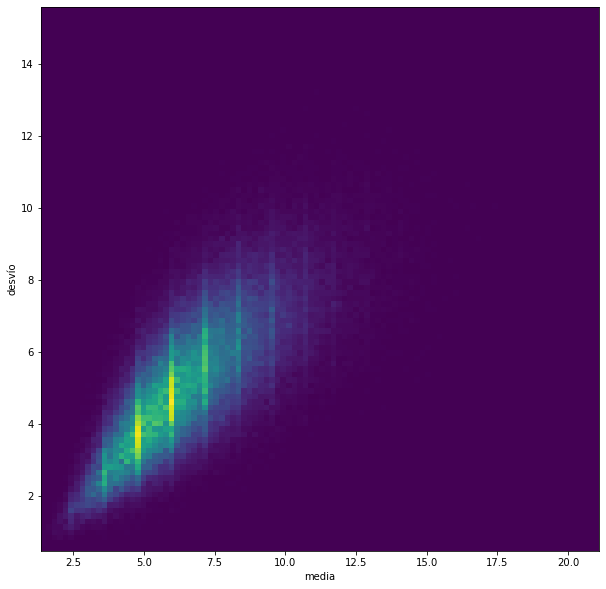

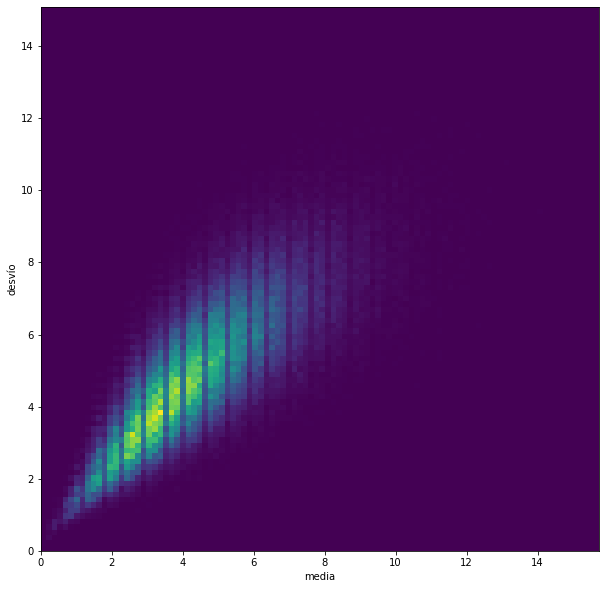

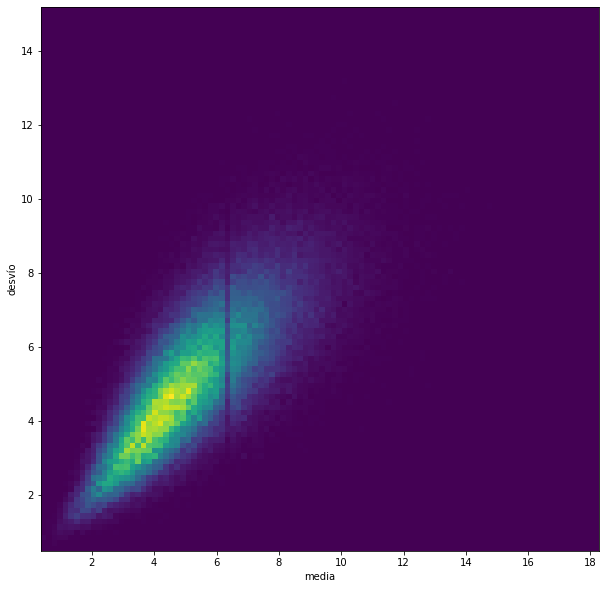

In [22]:
# a esta altura ya vios que el negro no es un solo color uniforme.
# ahora vamos a ver estadísticas globales de ruido de todos los píxeles por color

dec = 100

todos_los_rojos_std = np.ravel(img_std[:,:,0])
todos_los_rojos_media = np.ravel(img_media[:,:,0])

todos_los_verdes_std = np.ravel(img_std[:,:,1])
todos_los_verdes_media = np.ravel(img_media[:,:,1])

todos_los_azules_std = np.ravel(img_std[:,:,2])
todos_los_azules_media = np.ravel(img_media[:,:,2])

plt.figure(figsize=(10,10))
plt.xlabel('media')
plt.ylabel('desvío')
cb = plt.hist2d(todos_los_rojos_media[::dec], todos_los_rojos_std[::dec], bins=100)
 # plt.colorbar(cb)

plt.figure(figsize=(10,10))
plt.xlabel('media')
plt.ylabel('desvío')
cb = plt.hist2d(todos_los_verdes_media[::dec], todos_los_verdes_std[::dec], bins=100)
 # plt.colorbar(cb)

plt.figure(figsize=(10,10))
plt.xlabel('media')
plt.ylabel('desvío')
cb = plt.hist2d(todos_los_azules_media[::dec], todos_los_azules_std[::dec], bins=100)
 # plt.colorbar(cb)

# 4. Histograma

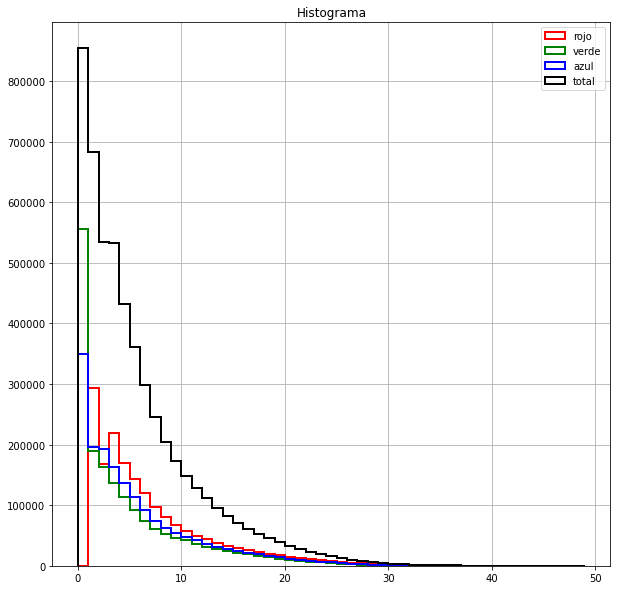

In [23]:
dec = 100
plt.figure(figsize=(10,10))
plt.title('Histograma')
todos_los_rojos = np.ravel(imgs_np[:,:,:,0])
todos_los_verdes = np.ravel(imgs_np[:,:,:,1])
todos_los_azules = np.ravel(imgs_np[:,:,:,2])
plt.grid()
i_max = 50
_ = plt.hist(todos_los_rojos[::dec], bins=range(i_max), color='red',histtype='step', linewidth=2.0)
_ = plt.hist(todos_los_verdes[::dec], bins=range(i_max), color='green', histtype='step', linewidth=2.0)
_ = plt.hist(todos_los_azules[::dec], bins=range(i_max), color='blue', histtype='step', linewidth=2.0)

_ = plt.hist(np.ravel(imgs_np)[::dec], bins=range(i_max), color='black', histtype='step', linewidth=2.0)
plt.legend(['rojo', 'verde', 'azul', 'total'])